In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

from seaborn import *


import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import figure

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras import layers

In [2]:
train_dir = "/content/drive/MyDrive/Facial recognition project/Dataset/train"
test_dir = "/content/drive/MyDrive/Facial recognition project/Dataset/test"

[4965, 7215, 4097, 4830, 3171, 3995, 436]


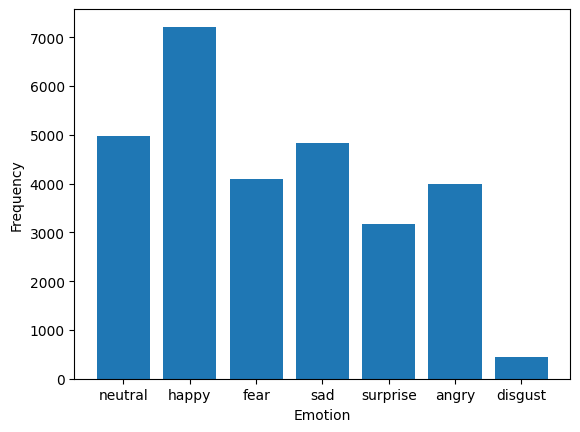

[958, 111, 1024, 1774, 1233, 831, 1247]


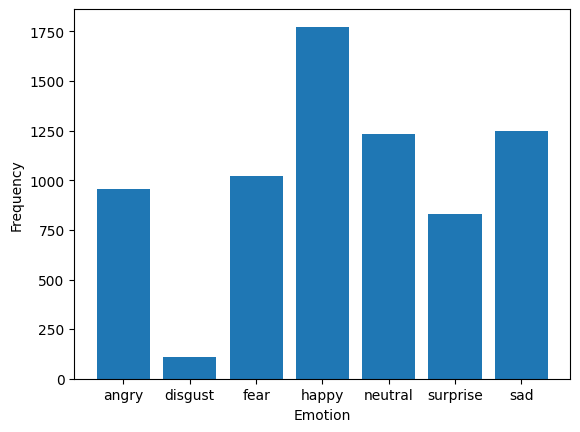

In [3]:
def emotion_dist(path):
    frequencies = {}
    emotions = []
    freq = []
    for emotion in os.listdir(path):
        emotions.append(emotion)
        freq.append(len(os.listdir(path + '/' + emotion)))
        #frequencies[emotion] = len(os.listdir(path + expression))
    plt.bar(emotions,freq, align='center')
    print(freq)
    plt.xlabel('Emotion')
    plt.ylabel('Frequency')
    plt.show()

emotion_dist(train_dir)
emotion_dist(test_dir)

In [4]:
# implementing on the fly data augmentation using ImageDataGetnerator
train_generator = ImageDataGenerator(rotation_range= 30,
                              rescale= 1.0/255,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              validation_split = 0.3)

training_data = train_generator.flow_from_directory(train_dir,
                                             target_size=(48,48),
                                             batch_size=16,
                                             color_mode = "grayscale",
                                             class_mode = "categorical",
                                             subset = 'training')

validation_data = train_generator.flow_from_directory(train_dir,
                                             target_size=(48,48),
                                             batch_size=16,
                                             color_mode = "grayscale",
                                             class_mode = "categorical",
                                             subset = 'validation')

Found 20099 images belonging to 7 classes.
Found 8610 images belonging to 7 classes.


In [5]:
# implementing on the fly data augmentation using ImageDataGetnerator for validation and testing
test_generator = ImageDataGenerator(rescale= 1.0/255)


test_data = test_generator.flow_from_directory(test_dir,
                                             target_size=(48,48),
                                             batch_size=16,
                                             color_mode = "grayscale",
                                             class_mode = "categorical")

Found 7178 images belonging to 7 classes.


In [6]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block
    X --> Input tensor
    f --> The kernel size of the middle conolution
    filters --> The number of filters that will be used in each of the three CONV layers
    training --> 1 for training, 0 for inference
    initializer --> How to set the initial weights of the network

    X as output is the output of this identity block
    """

    # Getting the number of filters that will be used in each conv
    F1, F2, F3 = filters

    # Saving the values of the inputs in order to use it in the skip connection
    X_shortcut = X

    # The convolutions of this block
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Add the values that we saved to the ones that we have
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [7]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=random_uniform):
    """
    Implementation of the identity block
    X --> Input tensor
    f --> The kernel size of the middle conolution
    filters --> The number of filters that will be used in each of the three CONV layers
    s --> specifiying the stride
    training --> 1 for training, 0 for inference
    initializer --> How to set the initial weights of the network

    X as output is the output of this identity block
    """

    # Getting the number of filters that will be used in each conv
    F1, F2, F3 = filters

    # Saving the values of the inputs in order to use it in the skip connection
    X_shortcut = X

    # The convolutions of this block
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)

    # The convolution on the input to be added as a skip connection
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)

    # Add the values that we saved to the ones that we have
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [8]:
def ResNet22(input_shape, classes):
    """
    input_shape --> shape of the images of the dataset
    classes --> number of classes

    model as output is a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)


    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])


    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    X = AveragePooling2D(pool_size = (2, 2))(X)

    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)

    model = Model(inputs = X_input, outputs = X)

    return model

In [9]:
# Define the size of your input images
side = 48  # You can change this to the appropriate size of your images

# Define the number of classes in your classification task
no_classes = 7  # Assuming you are recognizing 7 basic emotions


In [10]:

model = ResNet22(input_shape = (side, side, 1), classes = no_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 24, 24, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 24, 24, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                   

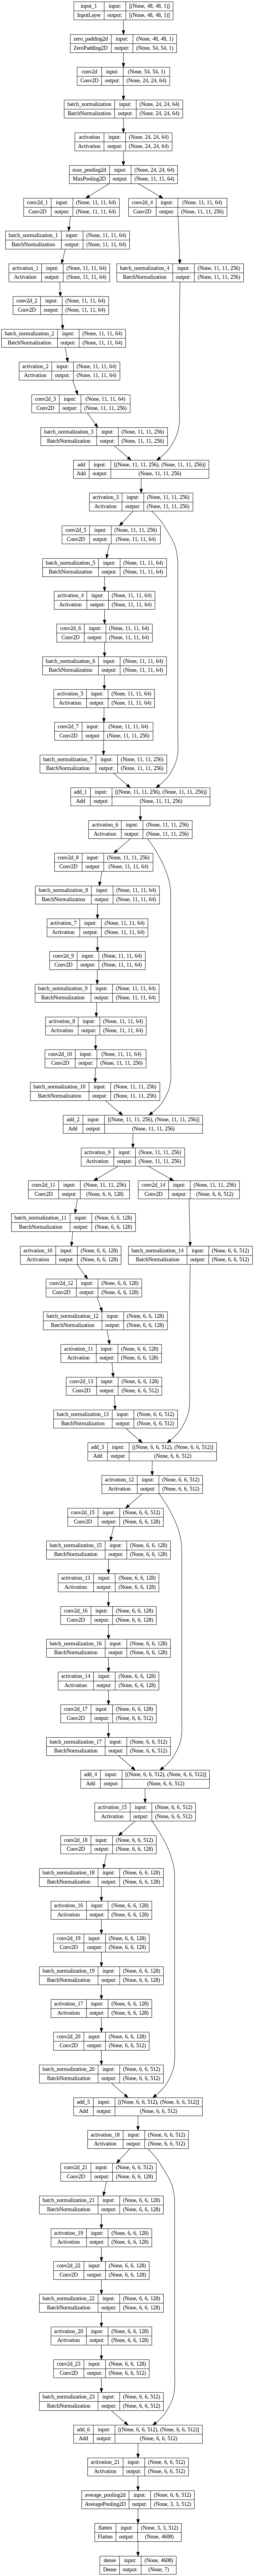

In [11]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')


In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(training_data, epochs=100, validation_data = validation_data)

Epoch 1/100
1257/1257 [==============================] - 5543s 4s/step - loss: 2.2511 - accuracy: 0.2323 - val_loss: 1.9448 - val_accuracy: 0.2485
Epoch 2/100
1257/1257 [==============================] - 86s 68ms/step - loss: 1.8418 - accuracy: 0.2668 - val_loss: 1.7516 - val_accuracy: 0.2900
Epoch 3/100
1257/1257 [==============================] - 83s 66ms/step - loss: 1.7397 - accuracy: 0.3000 - val_loss: 1.6989 - val_accuracy: 0.3151
Epoch 4/100
1257/1257 [==============================] - 82s 65ms/step - loss: 1.6676 - accuracy: 0.3338 - val_loss: 1.6154 - val_accuracy: 0.3654
Epoch 5/100
1257/1257 [==============================] - 82s 65ms/step - loss: 1.5920 - accuracy: 0.3721 - val_loss: 1.5665 - val_accuracy: 0.3814
Epoch 6/100
1257/1257 [==============================] - 82s 65ms/step - loss: 1.5188 - accuracy: 0.4086 - val_loss: 1.4819 - val_accuracy: 0.4295
Epoch 7/100
1257/1257 [==============================] - 82s 65ms/step - loss: 1.4580 - accuracy: 0.4340 - val_loss: 1

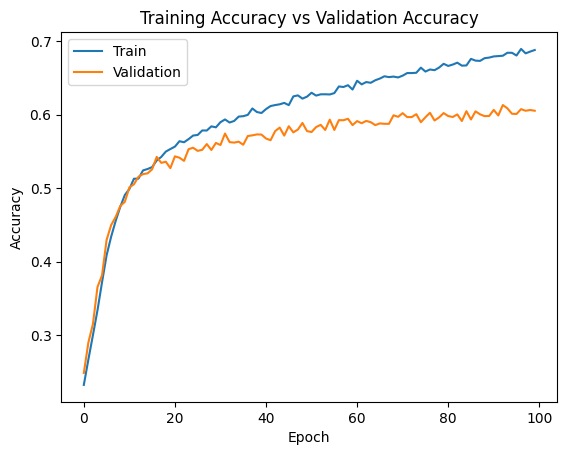

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
